# Prototype Model
---

* Regression
* 2009data로 class1,2,3 10fo
https://docs.google.com/presentation/d/1cI3teBcQoGBhfrdVrv9rnM4jHGaPToDS7Zh7t0q7GKg/edit#slide=id.g97e66187c6_0_6

In [1]:
import tensorflow as tf

In [2]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10644632304422114306,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2015962619349958193
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10862362624
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10839839769697288261
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12438431685699448190
 physical_device_desc: "device: XLA_GPU device"]

In [3]:
%env PYTHONHASHSEED=0
from random import seed as random_seed
random_seed(42)
from numpy.random import seed as np_random_seed
np_random_seed(42)

import glob
import os
import pprint
from tqdm import tqdm

from IPython import display
import ipywidgets as widgets

# Data Science
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

import cv2 as cv

env: PYTHONHASHSEED=0


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

## Paths
---

In [ ]:
so_type = 'so_rl'

input_path_root = r'/sgcwhb/Malocclusion/data/input_data/'

# output_path_root = r'../results/'
output_path_root = r'/sgcwhb/Malocclusion/results'
output_path = os.path.join(output_path_root, r'prototype_regression_so_img/', so_type)
# output_path_weight = os.path.join(output_path, r'weights/')

# try:
#     os.makedirs(output_path_weight)
# except FileExistsError as err: 
#     print(err)
# else:
#     print(output_path)
#     print(output_path_weight)

In [ ]:
input_path_root

In [ ]:
output_path_root

## Data
---
- Class 0 : 분별하기 어려운 data (65 sample) -> 제외

- Class 3 : 하악이 상악보다 앞으로 돌출된 경우 (1136 sample) -> -1.0
- Class 1 : 상하악의 맞물림 상태는 정상이지만 치열이 고르지 않은 경우 (1707 sample) -> 0.0
- Class 2 : 상악이 하악보다 앞으로 돌출된 경우 (1175 sample) -> 1.0


In [ ]:
def convert_label_class2reg(label_df):
    label_r = np.copy(label_df.angle_class_r)
    label_df.loc[label_r == 1, 'angle_class_r'] = 0
    label_df.loc[label_r == 2, 'angle_class_r'] = 1
    label_df.loc[label_r == 3, 'angle_class_r'] = -1
    
    label_l = np.copy(label_df.angle_class_l)
    label_df.loc[label_l == 1, 'angle_class_l'] = 0
    label_df.loc[label_l == 2, 'angle_class_l'] = 1
    label_df.loc[label_l == 3, 'angle_class_l'] = -1
    
    return label_df

def generate_data_by_patient(x, y):
    if x.shape[-1] == 12:
        x = np.concatenate([x[..., :3], x[..., 3:6], x[..., 6:9], x[..., 9:]])
        y = np.concatenate([y[:, 0], y[:, 1], y[:, 2], y[:, 3]])
    elif x.shape[-1] == 6:
        x = np.concatenate([x[..., :3], x[..., 3:]])
        y = np.concatenate([y[:, 0], y[:, 1]])
    
    return x, y

# def generate_info_df_by_patient(info_df):
#     info_df_r = info_df.copy()
#     for row_idx, info in enumerate(info_df_r['info']):
#         info_df_r.iloc[row_idx] = info + '_r'
        
#     info_df_l = info_df.copy()
#     for row_idx, info in enumerate(info_df_l['info']):
#         info_df_l.iloc[row_idx] = info + '_l'
    
#     info_df = pd.concat((info_df_r, info_df_l), ignore_index=True)
#     del info_df_r, info_df_l
    
#     info_df1 = info_df.copy()
        
#     info_df2 = info_df.copy()
#     for row_idx, info in enumerate(info_df2['info']):
#         info_df2.iloc[row_idx] = info.replace('01A1', '02B1')
    
#     info_df = pd.concat((info_df1, info_df2), ignore_index=True)
#     del info_df1, info_df2

#     return info_df

In [ ]:
x = np.load(os.path.join(input_path_root, f'data_KNU_Diorco_so_imgs.npy'))
label_df = pd.read_csv(os.path.join(input_path_root, f'data_KNU_Diorco_so_img_labels.csv'))
label_df = convert_label_class2reg(label_df)

y = label_df.loc[:, ['angle_class_r', 'angle_class_l']].to_numpy()

x = x.astype(np.float32)
y = y.astype(np.float32)

x = x / 127.5
x = x - 1.

#x = np.concatenate((x[::2, ...], x[1::2, ...]), axis=3)
#y = np.concatenate((y[::2, ...], y[1::2, ...]), axis=1)

In [ ]:
print(x.dtype, x.shape)
print(y.dtype, y.shape)
print()
display.display(label_df.info())
display.display(label_df)

plt.style.use('seaborn-whitegrid')
plt.figure()

plt.title('Label')
sns.countplot(np.concatenate([label_df.angle_class_r, label_df.angle_class_l]))

plt.show()
plt.style.use('seaborn-white')

In [ ]:
cnt = np.concatenate([label_df.angle_class_r, label_df.angle_class_l])
cnt.shape

In [ ]:
len(cnt[cnt==-1])

In [ ]:
len(cnt[cnt==0])

In [ ]:
len(cnt[cnt==1])

In [ ]:
len(cnt[cnt==-1]) + len(cnt[cnt==0]) + len(cnt[cnt==1])

## Model
---

In [ ]:
def build_model():
    base_model = InceptionResNetV2(include_top=False, weights=None, input_shape=(None, None, 3))

#     base_model.trainable = False

#     for layer in base_model.layers:
#         layer.trainable = False

    # base_model.summary()

    x = base_model.output

    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(256, activation='relu', name='dense')(x)
    x = layers.Dropout(0.2, name='dropout')(x)
    output_main = layers.Dense(1, name='output_main')(x)

    model = models.Model(inputs=base_model.input, outputs=output_main)
    
    return model

## Train the Model
---

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])):
    if kfold_idx==8:
        display.clear_output(wait=True)
        print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')
        
        x_train = x[train_idxs]
        y_train = y[train_idxs]
        label_df_train = label_df.iloc[train_idxs]

        x_train, x_val, y_train, y_val, label_df_train, label_df_val = train_test_split(x_train, y_train, label_df_train, test_size=0.2, 
                                                                                        random_state=42, stratify=y_train[:, 0])

        x_test = x[test_idxs]
        y_test = y[test_idxs]
        label_df_test = label_df.iloc[test_idxs]

        x_train, y_train = generate_data_by_patient(x_train, y_train)
        x_val, y_val = generate_data_by_patient(x_val, y_val)
        x_test, y_test = generate_data_by_patient(x_test, y_test)
        
        output_path_kfold = os.path.join(output_path, f'kfold_{kfold_idx + 1:02d}/')
        output_path_weight = os.path.join(output_path_kfold, r'weights/')
        
        if os.path.isdir(output_path_weight)==False:
            os.makedirs(output_path_weight)
            
        if kfold_idx == 0:
            model = build_model()

            model.compile(optimizer=optimizers.Adam(lr=1e-3),
                          loss=losses.MeanSquaredError(),
                          metrics=['mae'])

            model.save(os.path.join(output_path, r'model.hdf5'))

        # model.summary()
        else:
            model = models.load_model(os.path.join(output_path, r'model.hdf5'))
        
        checkpointer = callbacks.ModelCheckpoint(os.path.join(output_path_weight, 'weights_{epoch:08d}_{val_loss:.4g}.hdf5'),
                                                 save_weights_only=True)
        csv_logger = callbacks.CSVLogger(os.path.join(output_path_kfold, r'log.csv'), append=True)
        
        # Training batch size 16 -> 8
        model.fit(x_train, y_train,
                  batch_size=8,
                  epochs=50,
                  validation_data=(x_val, y_val),
                  callbacks=[checkpointer, csv_logger],
                  initial_epoch=7,
                  verbose=1)

        K.clear_session()
        del model

## Evaluation
---

In [ ]:
metrics = []
predictions_kfold = []
labels_kfold = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])):
    print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')
    
    # 1. Data
    # ----------------------------------------
    
    x_test = x[test_idxs]
    y_test = y[test_idxs]
    label_df_test = label_df.iloc[test_idxs]
    
    x_test, y_test = generate_data_by_patient(x_test, y_test)
    
    # 2. Paths
    # ----------------------------------------
    
    output_path_kfold = os.path.join(output_path, f'kfold_{kfold_idx + 1:02d}/')
    output_path_weight = os.path.join(output_path_kfold, r'weights/')

    # 3. Plot Learning Curves.
    # ----------------------------------------
    
    log_df = pd.read_csv(os.path.join(output_path_kfold, r'log.csv'))
    
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(16, 6))
    
    plt.subplot(121)
    plt.title(f'Learning Curves ({kfold_idx + 1:02d}/{kfold.n_splits:02d})')
    plt.plot(log_df.loss)
    plt.plot(log_df.val_loss)
    plt.ylim(0, 1.5)
    plt.legend(('Train Loss', 'Validation Loss'))
    
    plt.subplot(122)
    plt.plot(log_df.mae)
    plt.plot(log_df.val_mae)
    plt.ylim(0, 1.5)
    plt.legend(('Train MAE', 'Validation MAE'))
    
    plt.show()
    plt.style.use('seaborn-white')
    print(f'Min. validation loss epoch: {log_df.val_loss.idxmin() + 1}')
    print(f'Min. validation MAE epoch: {log_df.val_mae.idxmin() + 1}')
    
    # 4. Load a Model.
    # ----------------------------------------
    
    K.clear_session()
    
    model = models.load_model(os.path.join(output_path, r'model.hdf5'))
    model.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_mae.idxmin() + 1:08d}*.hdf5'))[0])
    
    # 5. Display
    # ----------------------------------------

    

    predictions_test = model.predict(x_test)
    predictions_kfold.append(predictions_test.ravel())
    labels_kfold.append(y_test)
    metrics.append(model.evaluate(x_test, y_test, verbose=0))
    
    plt.figure(figsize=(16, 8))

    plt.subplot(121)
    data_idx1 = 0
    title = ' '.join(map(str, label_df_test.iloc[data_idx1, :3]))
    prediction = predictions_test[data_idx1, 0]
    plt.title(f'{title} (R)')
    plt.imshow((x_test[data_idx1] + 1) / 2)
    plt.xlabel(f'Label: {y_test[data_idx1]}\nPrediction: {round(prediction)} ({prediction:.3f})')
    
    plt.subplot(122)
    data_idx2 = data_idx1 + len(x_test) // 2
    prediction = predictions_test[data_idx2, 0]
    plt.title(f'{title} (L)')
    plt.imshow((np.fliplr(x_test[data_idx2]) + 1) / 2)
    plt.xlabel(f'Label: {y_test[data_idx2]}\nPrediction: {round(prediction)} ({prediction:.3f})')

    plt.show()
    print('', end='\n\n')
else:
    predictions_prob_kfold = np.concatenate(predictions_kfold)
    predictions_kfold = np.round(predictions_prob_kfold)
#     predictions_kfold[predictions_kfold < -1] = -1
#     predictions_kfold[predictions_kfold > 1] = 1
    labels_kfold = np.concatenate(labels_kfold)

In [ ]:
kfold_results_df = pd.DataFrame(metrics, columns=('test_loss', 'test_mae'))

kfold_results_df

In [ ]:
kfold_results_df.describe()

In [ ]:
predictions_kfold.shape

In [ ]:
cm = confusion_matrix(labels_kfold, predictions_kfold, labels=[-1, 0, 1])

print(cm)
print("")
print(f'Accuracy: {(cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum():.3f}')

In [ ]:
print(791 +311   +29+128+ 1437  +142+11+  225 + 939)


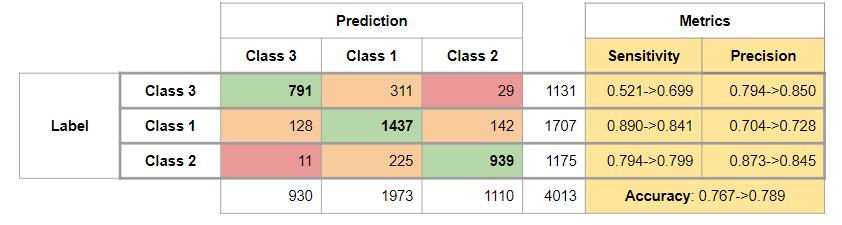

1. sensitivity, precision
2. threshold값 